In [50]:
import os
os.environ['DGLBACKEND'] = 'mxnet'
import dgl
import networkx as nx
import mxnet as mx
from mxnet import gluon
import math
import numpy as np
import dgl.function as fn

In [2]:
def disjoint_chains(n_chains, length):
    path_graph = nx.path_graph(n_chains * length).to_directed()
    for i in range(n_chains - 1):  # break the path graph into N chains
        path_graph.remove_edge((i + 1) * length - 1, (i + 1) * length)
        path_graph.remove_edge((i + 1) * length, (i + 1) * length - 1)
    for n in path_graph.nodes:
        path_graph.add_edge(n, n)  # add self connections
    return path_graph

In [3]:
g1 = disjoint_chains(1, 30)
nx.draw(g1, pos=nx.circular_layout(g1))

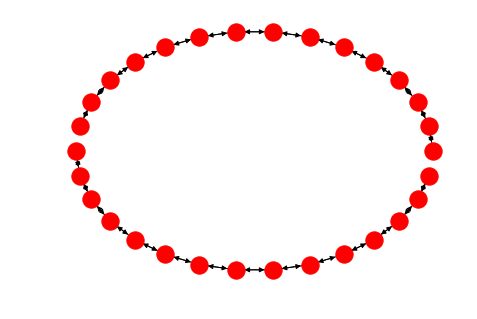

In [4]:
g2 = disjoint_chains(2, 15)
nx.draw(g2, pos=nx.circular_layout(g2))

In [320]:
n_train_samples = 5000
n_epochs = 100
lr = 1e-3
weight_decay = 5e-4

g = dgl.DGLGraph(disjoint_chains(1, 10000), readonly=True)
labels = mx.nd.zeros([g.number_of_nodes()])
#pattern = [0, 1] # This can be classified.
#pattern = [0, 1, 1, 1] # This can be classified.
pattern = [0, 1, 0, 1, 1, 0] # This can't be classified.
#pattern = [0, 1, 1, 0, 1, 1, 1, 0] # This can be classified.
for i in range(int(g.number_of_nodes()/len(pattern))):
    labels[i*len(pattern):(i + 1) * len(pattern)] = pattern

train_mask = mx.nd.zeros((g.number_of_nodes()))
train_mask[np.random.randint(0, g.number_of_nodes(), size=n_train_samples)] = 1
eval_mask = 1 - train_mask
n_train_samples = mx.nd.sum(train_mask).asnumpy()[0]

def evaluate(pred, labels, mask):
    pred = pred.argmax(axis=1)
    accuracy = ((pred == labels) * mask).sum() / mask.sum().asscalar()
    return accuracy.asscalar()

# Helper function to convert a number 
# to its fixed width binary representation
def conv(x):
  a = format(x, '032b')
  l = list(str(a))
  l = np.array(list(map(int, l)))
  return l

## Here we predict with MLP

In [317]:
n_hidden = 16
n_classes = 2

class MLP(gluon.Block):
    def __init__(self,
                 n_hidden,
                 n_classes,
                 activation,):
        super(MLP, self).__init__()
        self.dense1 = gluon.nn.Dense(n_hidden, activation=activation)
        self.dense2 = gluon.nn.Dense(n_classes)

    def forward(self, features):
        h = features
        return self.dense2(self.dense1(h))

In [318]:
model = MLP(n_hidden, n_classes, 'relu')
model.initialize()
features = mx.nd.array([conv(i) for i in range(g.number_of_nodes())])
trainer = gluon.Trainer(model.collect_params(), 'adam',
                        {'learning_rate': lr, 'wd': weight_decay})

loss_fcn = gluon.loss.SoftmaxCELoss()
for epoch in range(1000):
    with mx.autograd.record():
        pred = model(features)
        loss = loss_fcn(pred, labels, mx.nd.expand_dims(train_mask, 1))
        loss = loss.sum() / n_train_samples
    loss.backward()
    trainer.step(batch_size=1)
    
    acc = evaluate(pred, labels, eval_mask)
print("loss: " + str(loss.asnumpy()) + ", acc: " + str(acc))

loss: [0.00574109], acc: 1.0


In [319]:
def rotate(feats, i):
    if i == 0:
        return feats
    
    data = mx.nd.zeros(feats.shape)
    data[0:i] = feats[(data.shape[0] - i):]
    data[i:] = feats[0:(data.shape[0] - i)]
    return data
    
model = MLP(n_hidden, n_classes, 'relu')
model.initialize()
base_feats = mx.nd.array([conv(i) for i in range(g.number_of_nodes())])
features = [rotate(base_feats, i) for i in range(len(pattern))]
features = mx.nd.concat(*features, dim=1)
trainer = gluon.Trainer(model.collect_params(), 'adam',
                        {'learning_rate': lr, 'wd': weight_decay})

loss_fcn = gluon.loss.SoftmaxCELoss()
for epoch in range(1000):
    with mx.autograd.record():
        pred = model(features)
        loss = loss_fcn(pred, labels, mx.nd.expand_dims(train_mask, 1))
        loss = loss.sum() / n_train_samples
    loss.backward()
    trainer.step(batch_size=1)
    
    acc = evaluate(pred, labels, eval_mask)
print("loss: " + str(loss.asnumpy()) + ", acc: " + str(acc))

loss: [0.00170058], acc: 1.0


## Here we define a GNN model

In [291]:
n_hidden = 16
n_classes = 2

class GCNLayer(gluon.Block):
    def __init__(self,
                 g,
                 in_feats,
                 out_feats,
                 activation):
        super(GCNLayer, self).__init__()
        self.g = g
        self.dense = gluon.nn.Dense(out_feats, activation=activation)

    def forward(self, h):
        self.g.ndata['h'] = h
        def concat_msg(edges):
            return {'m': edges.src['h']}
        def red_func(nodes):
            m = nodes.mailbox['m']
            if m.shape[1] == 3:
                h = m.reshape(m.shape[0], m.shape[1] * m.shape[2])
                h = mx.nd.concat(h, nodes.data['h'], dim=1)
            else:
                num_feats = m.shape[2]
                m = m.reshape(m.shape[0], m.shape[1] * m.shape[2])
                h = mx.nd.concat(m, nodes.data['h'], mx.nd.zeros(shape=(m.shape[0], num_feats)), dim=1)
            return {'h': self.dense(h)}
        self.g.update_all(concat_msg, red_func)
        return mx.nd.concat(self.g.ndata.pop('h'), h, dim=1)

class GCN(gluon.Block):
    def __init__(self,
                 g,
                 in_feats,
                 n_hidden,
                 n_classes,
                 n_layers,
                 activation,
                 dropout):
        super(GCN, self).__init__()
        self.layers = gluon.nn.Sequential()
        # input layer
        self.layers.add(GCNLayer(g, in_feats, n_hidden, activation))
        # hidden layers
        for i in range(n_layers - 1):
            self.layers.add(GCNLayer(g, n_hidden, n_hidden, activation))
        self.dense1 = gluon.nn.Dense(n_hidden, activation=activation)
        self.dense2 = gluon.nn.Dense(n_classes)

    def forward(self, features):
        h = features
        for layer in self.layers:
            h = layer(h)
        return self.dense2(self.dense1(h))

In [292]:
degs = g.in_degrees().astype('float32')
norm = mx.nd.power(degs, -0.5)
g.ndata['norm'] = mx.nd.expand_dims(norm, 1)
features = mx.nd.array([conv(i) for i in range(g.number_of_nodes())])
model = GCN(g, in_feats=features.shape[1], n_hidden=16, n_classes=2, n_layers=3, activation='relu', dropout=0.5)
model.initialize()
trainer = gluon.Trainer(model.collect_params(), 'adam',
            {'learning_rate': lr, 'wd': weight_decay})

h = model(features)
loss_fcn = gluon.loss.SoftmaxCELoss()
for epoch in range(100):
    with mx.autograd.record():
        pred = model(features)
        loss = loss_fcn(pred, labels, mx.nd.expand_dims(train_mask, 1))
        loss = loss.sum() / n_train_samples
    loss.backward()
    trainer.step(batch_size=1)
    
    acc = evaluate(pred, labels, eval_mask)
print(acc)

/Users/dzzhen/Workspace/dgl/python/dgl/base.py:17: UserWarning: Initializer is not set. Use zero initializer instead. To suppress this warning, use `set_initializer` to explicitly specify which initializer to use.
  warnings.warn(msg)


0.5909139


## here we define an SSE model

In [321]:
class SteadyStateOperator(gluon.Block):
    def __init__(self, n_hidden, activation, **kwargs):
        super(SteadyStateOperator, self).__init__(**kwargs)
        with self.name_scope():
            self.dense1 = gluon.nn.Dense(n_hidden, activation=activation)
            self.dense2 = gluon.nn.Dense(n_hidden)

    def forward(self, g):
        def concat_msg(edges):
            return {'m': edges.src['xh']}
        def red_func(nodes):
            m = nodes.mailbox['m']
            if m.shape[1] == 3:
                h = m.reshape(m.shape[0], m.shape[1] * m.shape[2])
                h = mx.nd.concat(h, nodes.data['h'], dim=1)
            else:
                num_feats = m.shape[2]
                m = m.reshape(m.shape[0], m.shape[1] * m.shape[2])
                h = mx.nd.concat(m, nodes.data['h'], mx.nd.zeros(shape=(m.shape[0], num_feats)), dim=1)
            return {'h': self.dense2(self.dense1(h))}
        
        g.ndata['xh'] = mx.nd.concat(g.ndata['x'], g.ndata['h'], dim=1)
        g.update_all(concat_msg, red_func)
        return g.ndata['h']

def update_embeddings(g, steady_state_operator):
    prev_h = g.ndata['h']
    next_h = steady_state_operator(g)
    g.ndata['h'] = (1 - alpha) * prev_h + alpha * next_h
    
class Predictor(gluon.Block):
    def __init__(self, n_hidden, activation, **kwargs):
        super(Predictor, self).__init__(**kwargs)
        with self.name_scope():
            self.dense1 = gluon.nn.Dense(n_hidden, activation=activation)
            self.dense2 = gluon.nn.Dense(2)  ## binary classifier

    def forward(self, g):
        g.ndata['z'] = self.dense2(self.dense1(g.ndata['h']))
        return g.ndata['z']

In [ ]:
n = g.number_of_nodes()
n_hidden = 32
n_embedding_updates = 1
n_parameter_updates = 1
alpha = 0.1
batch_size = 64
lr = 1e-1

g.ndata['x'] = mx.nd.array([conv(i) for i in range(n)])
#g.ndata['x'] = mx.nd.arange(n).reshape(n, 1)
g.ndata['h'] = mx.nd.random.normal(shape=(n, n_hidden))

steady_state_operator = SteadyStateOperator(n_hidden, 'relu')
steady_state_operator.initialize()
predictor = Predictor(n_hidden, 'relu')
predictor.initialize()
trainer = gluon.Trainer(predictor.collect_params(), 'adam',
                        {'learning_rate': lr, 'wd': weight_decay})

def update_parameters(g, trainer):
    with mx.autograd.record():
        steady_state_operator(g)
        z = predictor(g)
        loss = loss_fcn(z, labels, mx.nd.expand_dims(train_mask, 1))
        loss = loss.sum() / n_train_samples
        print("loss: " + str(loss.asnumpy()))
    loss.backward()
    trainer.step(1)  # divide gradients by the number of labelled nodes
    return loss.asnumpy()[0]

def train(g, trainer):
     # first phase
    for i in range(n_embedding_updates):
        update_embeddings(g, steady_state_operator)
    # second phase
    for i in range(n_parameter_updates):
        loss = update_parameters(g, trainer)
    return loss

for epoch in range(1000):
    train(g, trainer)
    acc = evaluate(g.ndata['z'], labels, eval_mask)
    print(acc)

/Users/dzzhen/Workspace/dgl/python/dgl/base.py:17: UserWarning: Initializer is not set. Use zero initializer instead. To suppress this warning, use `set_initializer` to explicitly specify which initializer to use.
  warnings.warn(msg)


loss: [0.6931569]
0.4930853
loss: [0.69690686]
0.49802437
loss: [0.72387487]
0.50197566
loss: [0.69428223]
0.50197566
loss: [0.6933636]
0.49802437
loss: [0.69891757]
0.49802437
loss: [0.69880486]
0.49802437
loss: [0.6971408]
0.49802437
loss: [0.6941411]
0.49802437
loss: [0.6913432]
0.49802437
loss: [0.6904655]
0.51284164
loss: [0.6906769]
0.50197566
loss: [0.68948287]
0.5301284
loss: [0.687774]
0.5935133
loss: [0.6865534]
0.5615739
loss: [0.6841595]
0.57342774
loss: [0.6816937]
0.59976953
loss: [0.679896]
0.59812313
loss: [0.6767465]
0.60190976
loss: [0.6752209]
0.59680605
loss: [0.67245495]
0.60487324
loss: [0.67028856]
0.61228186
loss: [0.6689542]
0.6070135
loss: [0.6658506]
0.62314785
loss: [0.66488844]
0.62232465
loss: [0.6636536]
0.6244649
loss: [0.66139287]
0.6351663
loss: [0.6607401]
0.63697726
loss: [0.6610206]
0.6302272
loss: [0.6599398]
0.6404346
loss: [0.65786797]
0.6483372
loss: [0.65722346]
0.6516299
loss: [0.6581288]
0.64866644
loss: [0.6585834]
0.64290416
loss: [0.656921

loss: [0.6504789]
0.66101414
loss: [0.65041745]
0.66134346
loss: [0.6504233]
0.66134346
loss: [0.65044934]
0.66117877
loss: [0.65050656]
0.6624959
loss: [0.6507195]
0.6587092
loss: [0.65083325]
0.6600264
loss: [0.6508524]
0.6585446
loss: [0.6508909]
0.6600264
loss: [0.6510417]
0.6580507
loss: [0.65086824]
0.6593678
loss: [0.65078115]
0.6595324
loss: [0.650621]
0.66183734
loss: [0.65044874]
0.6603556
loss: [0.6503683]
0.66134346
loss: [0.65039873]
0.6624959
loss: [0.65046453]
0.6603556
loss: [0.65053505]
0.6621666
loss: [0.65072805]
0.6585446
loss: [0.6507711]
0.66052026
loss: [0.650709]
0.6587092
loss: [0.6505907]
0.6608495
loss: [0.65047127]
0.6598617
loss: [0.65036416]
0.6629898
loss: [0.6503183]
0.66101414
loss: [0.65040517]
0.66101414
loss: [0.6506407]
0.66183734
loss: [0.65104353]
0.65903854
loss: [0.65129894]
0.6587092
loss: [0.6516115]
0.6549226
loss: [0.6514921]
0.6562397
loss: [0.6513734]
0.6562397
loss: [0.6508185]
0.65969706
loss: [0.6504475]
0.6615081
loss: [0.6503621]
0.66

loss: [0.65102184]
0.6580507
loss: [0.65047204]
0.6608495
loss: [0.6502432]
0.6606849
loss: [0.6504995]
0.6603556
loss: [0.65090424]
0.6593678
loss: [0.651097]
0.6575568
loss: [0.6510139]
0.6595324
loss: [0.65048313]
0.660191
loss: [0.6503395]
0.6600264
loss: [0.65096265]
0.65969706
loss: [0.6518175]
0.6539348
loss: [0.6514045]
0.6572275
loss: [0.65044254]
0.6608495
loss: [0.65054345]
0.660191
loss: [0.65119535]
0.6598617
loss: [0.65110546]
0.6580507
loss: [0.65050256]
0.6623312
loss: [0.65041214]
0.6603556
loss: [0.6505811]
0.6600264
loss: [0.6505413]
0.66117877
loss: [0.6504098]
0.66052026
loss: [0.65044075]
0.660191
loss: [0.6503974]
0.6621666
loss: [0.6504349]
0.6603556
loss: [0.65050316]
0.6621666
loss: [0.65041465]
0.66052026
loss: [0.65035695]
0.6629898
loss: [0.6504015]
0.66117877
loss: [0.6503398]
0.66117877
loss: [0.6505125]
0.66183734
loss: [0.6508468]
0.6595324
